In [ ]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
BASE_URL = '/content/drive/MyDrive/Colab Notebooks/MLT/owd'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# df_owd = pd.read_csv("./dataset/1990-2020_day.csv", parse_dates=True)
df_owd = pd.read_csv(os.path.join(BASE_URL,"1990-2020_day.csv"), parse_dates=True)
df_owd['dt_iso'] = pd.to_datetime(df_owd['dt_iso'])
df_owd.head()

,dt_iso,temp_mean,temp_min_min,temp_max_max,pressure_mean,humidity_mean,wind_speed_mean,wind_deg_mean,clouds_all_mean,rain_1d
0,1990-01-01,26.333750,25.03,27.40,1009.333333,85.416667,1.477083,194.291667,91.541667,9.40
1,1990-01-02,25.559583,24.92,26.55,1009.666667,87.541667,2.096667,247.458333,99.958333,36.71
2,1990-01-03,26.956667,26.09,27.52,1008.583333,82.250000,2.122083,271.125000,96.000000,5.02
3,1990-01-04,26.638750,25.91,27.15,1007.958333,84.541667,2.652500,202.458333,98.541667,10.54
4,1990-01-05,27.940417,27.40,28.83,1007.916667,78.708333,2.905000,131.458333,99.708333,0.71


## EDA

Pola curah hujan dalam satu tahun

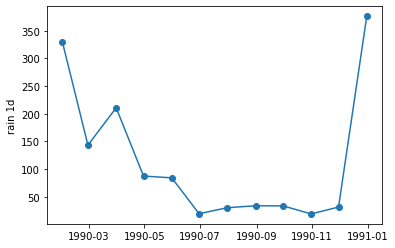

In [ ]:
df_1990 = df_owd[(df_owd['dt_iso'] >= '1990-01-01') & (df_owd['dt_iso'] <= '1990-12-31')]
plt.plot(df_1990.groupby([pd.Grouper(key='dt_iso', freq='M')]).rain_1d.sum(), marker='o')
plt.ylabel("rain 1d")
plt.show()

Dari plot terlihat data mengikuti pola yang valid

- Denpasar mengikuti pola Monsoon, 
- Puncak musim hujan berada di **Dec-Jan-Feb (DJF)**
- Puncak musim kemarau berada di **Jun-Jul-Aug (JJA)**

<img src='images/pola.jpeg'></img>

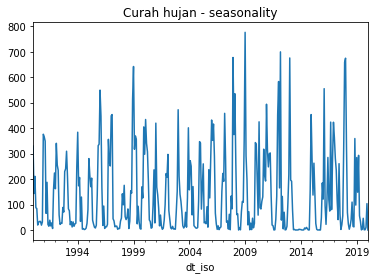

In [ ]:
df_owd.groupby([pd.Grouper(key='dt_iso', freq='M')]).rain_1d.sum().plot()
plt.title('Curah hujan - seasonality')
plt.show()

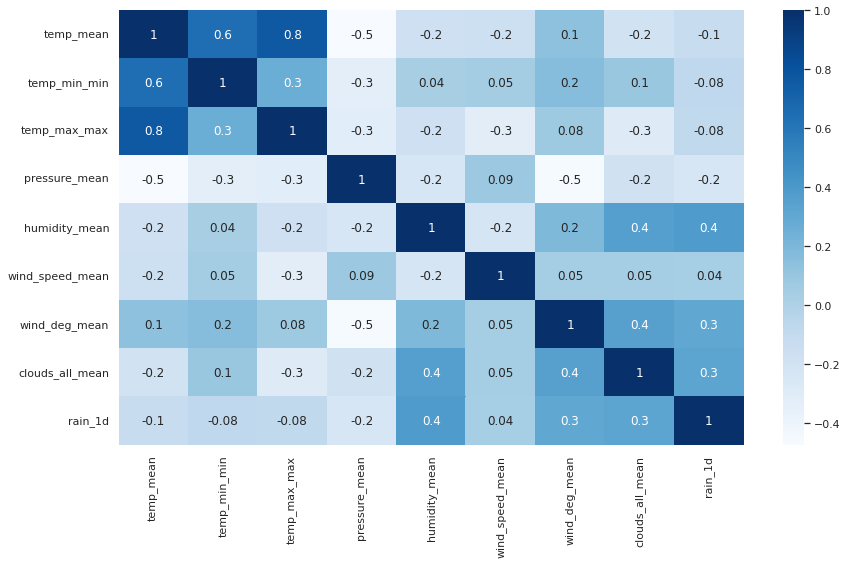

In [ ]:
plt.figure(figsize=(14,8))
sns.set_theme(style="white")
corr = df_owd.corr()
heatmap = sns.heatmap(corr, annot=True, cmap="Blues", fmt='.1g')

Hasil korelasi parameter tidak ada korelasi yang kuat antara curah hujan dan parameter lainnya

Namun pada riset ini diangkut semua paramater karena parameter tersebut yang biasa dipakai dalam prediksi curah hujan

### Dataset Statistik

In [ ]:
df_owd.describe()

,temp_mean,temp_min_min,temp_max_max,pressure_mean,humidity_mean,wind_speed_mean,wind_deg_mean,clouds_all_mean,rain_1d
count,10964.000000,10964.000000,10964.000000,10964.000000,10964.000000,10964.000000,10964.000000,10964.000000,10964.000000
mean,27.273347,24.848543,30.145240,1010.043557,80.814358,3.615097,157.916497,38.428085,4.545826
std,1.069445,1.391260,1.551929,1.995368,4.300660,1.394986,63.101959,14.729778,12.830629
min,22.401250,2.000000,23.200000,1001.129167,61.958333,0.998333,48.000000,6.083333,0.000000
25%,26.510208,24.000000,29.000000,1008.719792,78.125000,2.560729,111.291667,28.333333,0.000000
50%,27.337500,25.000000,30.000000,1010.125000,80.875000,3.402708,124.833333,35.000000,0.180000
75%,28.070729,25.800000,31.000000,1011.483333,83.666667,4.399271,207.666667,44.541667,2.310000
max,31.339167,28.800000,39.800000,1017.037500,98.000000,12.765833,321.250000,100.000000,221.000000


Terlihat terjadi data error pada temperatur minimum, tidak mungkin di daerah Denpasar mengalami suhu 2 derajat

Oleh karena itu, dilakukan cleansing dengan mengganti nilai temp_min_min < 22.4 dengan nilai 22.4 yaitu diambil dari temperture_mean minimum

### Cleansing

In [ ]:
df_owd.loc[(df_owd['temp_min_min'] < 22.4), 'temp_min_min'] = 22.4

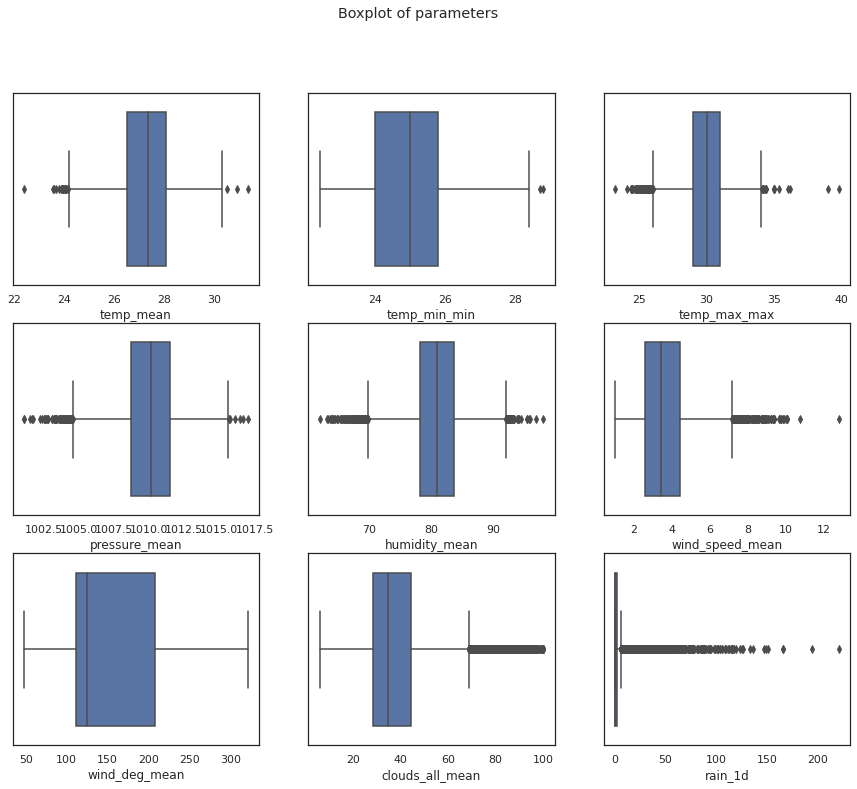

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Boxplot of parameters')
i, j = 0, 0
for c in df_owd:
    if c != 'dt_iso':
        sns.boxplot(ax=axes[i, j], x=df_owd[c])

        j = j + 1
        if j >= 3:
            j = 0
            i = i + 1

Dari boxplot dapat dilihat bahwa yang mendekati distribusi normal hanyalah **temp_mean, pressure_mean, humidity_mean dan wind_deg_mean**

Sehingga untuk keseragaman maka normalisasi tidak menggunakan z-score melainkan min-max,  

## Preprocess

In [ ]:
df_owd_train = df_owd[(df_owd['dt_iso'] <= '2018-12-31')]
df_owd_test = df_owd[(df_owd['dt_iso'] >= '2019-01-01') & (df_owd['dt_iso'] <= '2019-12-31')] # ignore 2020

In [ ]:
df_owd = df_owd.set_index('dt_iso')
df_owd_train = df_owd_train.set_index('dt_iso')
df_owd_test = df_owd_test.set_index('dt_iso')

In [ ]:
sc = MinMaxScaler(feature_range = (0, 1))
norm_df_owd = sc.fit_transform(df_owd_train)

norm_df_owd

array([[0.43997949, 0.4109375 , 0.25301205, ..., 0.53537664, 0.90993789,
        0.04253394],
       [0.35336348, 0.39375   , 0.20180723, ..., 0.72994815, 0.99955634,
        0.1661086 ],
       [0.50967321, 0.5765625 , 0.26024096, ..., 0.81655993, 0.95740905,
        0.02271493],
       ...,
       [0.6979628 , 0.625     , 0.48192771, ..., 0.83074108, 0.26796806,
        0.01900452],
       [0.68220596, 0.5625    , 0.48192771, ..., 0.81091796, 0.17258208,
        0.        ],
       [0.70807888, 0.5625    , 0.53012048, ..., 0.41445563, 0.42502218,
        0.01040724]])

In [ ]:
# norm_df_owd = norm_df_owd.reset_index()

### Windowing dataset

In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  print(start_index)
  print(end_index)
  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [ ]:
past_history = 365 # 730 # 1095 # 
future_target = 365
n_feature = 9
STEP = 1 # 6
TRAIN_SPLIT = 9861 # 9496 # 9131# 2016

x_train_multi, y_train_multi = multivariate_data(norm_df_owd, norm_df_owd[:, 8], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(norm_df_owd, norm_df_owd[:, 8],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

365
9861
10226
10227


In [ ]:
print(x_train_multi.shape, x_val_multi.shape)

(9496, 365, 9) (1, 365, 9)


## Model

In [ ]:
# model = keras.models.Sequential([
#   keras.layers.Bidirectional(keras.layers.LSTM(units=64, return_sequences = True, input_shape=(past_history, n_feature))),
#   keras.layers.Dropout(0.2),
#   keras.layers.Bidirectional(keras.layers.LSTM(units=64, return_sequences = True)),
#   keras.layers.Dropout(0.2),
#   keras.layers.Bidirectional(keras.layers.LSTM(units=32)),
#   keras.layers.Dropout(0.2),
#   keras.layers.Dense(128, activation='sigmoid'),
#   keras.layers.Dropout(0.2),
#   keras.layers.Dense(units = future_target, activation='sigmoid')
# ])
model = keras.models.Sequential([
  keras.layers.Bidirectional(keras.layers.GRU(units=512, return_sequences = True, input_shape=(past_history, n_feature))),
  keras.layers.Dropout(0.2),
  keras.layers.Bidirectional(keras.layers.GRU(units=256)),
  keras.layers.Dropout(0.2),
  keras.layers.Dense(units = future_target, activation='sigmoid')
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss = 'mean_squared_error')

In [ ]:
epoch = 40
batch_size = 128
model.fit(x_train_multi, y_train_multi, validation_data=(x_val_multi, y_val_multi), epochs = epoch, batch_size = batch_size)

Epoch 1/40
75/75 [==============================] - 42s 388ms/step - loss: 0.0095 - val_loss: 0.0036
Epoch 2/40
75/75 [==============================] - 28s 378ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 3/40
75/75 [==============================] - 29s 385ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 4/40
75/75 [==============================] - 29s 392ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 5/40
75/75 [==============================] - 30s 401ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 6/40
75/75 [==============================] - 30s 406ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 7/40
75/75 [==============================] - 30s 403ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 8/40
75/75 [==============================] - 30s 402ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 9/40
75/75 [==============================] - 30s 402ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 10/40
75/75 [==============================] - 30s 402ms/step - loss: 0.0033 - val_lo

In [ ]:
model.save(os.path.join(BASE_URL,'model1.h5'))

### Testing dan Predict 2019

In [ ]:
X_predict = norm_df_owd[-past_history:].reshape((-1, past_history, n_feature))

In [ ]:
hasil = model.predict(X_predict)

In [ ]:
max = sc.data_max_[-1]
min = sc.data_min_[-1]
y_descaled = hasil * (max - min) + min
# y_descaled

In [ ]:
total_1d_predicted = pd.Series(y_descaled.flatten(), name='total_1d_predicted')

df_owd_test = df_owd_test.reset_index()
aggregated_2019_df = pd.concat([df_owd_test, total_1d_predicted], axis=1)

In [ ]:
rain_1M_2019 = aggregated_2019_df.groupby([pd.Grouper(key='dt_iso', freq='M')]).rain_1d.sum()
rain_1M_2019_pred = aggregated_2019_df.groupby([pd.Grouper(key='dt_iso', freq='M')]).total_1d_predicted.sum()

# (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
rain_1M_2019 = (rain_1M_2019 - min) / (max - min)
rain_1M_2019_pred = (rain_1M_2019_pred - min) / (max - min)
mse = ((rain_1M_2019_pred - rain_1M_2019) ** 2).sum() / 12
print(mse)

0.09880431247997375


In [ ]:
aggregated_2019_df.head()

,dt_iso,temp_mean,temp_min_min,temp_max_max,pressure_mean,humidity_mean,wind_speed_mean,wind_deg_mean,clouds_all_mean,rain_1d,total_1d_predicted
0,2019-01-01,28.408333,25.6,30.4,1008.875000,82.125,4.566667,255.000000,29.000000,3.30,10.305034
1,2019-01-02,27.624167,25.6,30.0,1008.875000,80.250,6.125000,284.583333,28.125000,1.20,9.155698
2,2019-01-03,27.597500,25.0,30.0,1010.333333,77.125,4.203333,248.583333,32.291667,1.21,11.169362
3,2019-01-04,28.393333,25.9,31.0,1011.000000,76.750,2.120417,153.416667,28.291667,0.00,8.648003
4,2019-01-05,28.671200,26.0,31.2,1011.080000,81.800,1.971600,109.880000,40.000000,1.00,12.403822


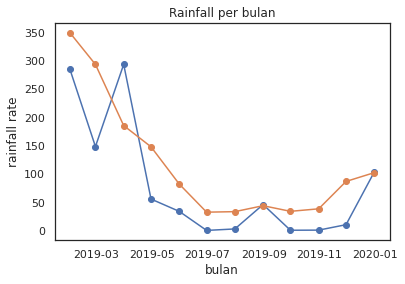

In [ ]:
plt.plot(aggregated_2019_df.groupby([pd.Grouper(key='dt_iso', freq='M')]).rain_1d.sum(), marker='o')
plt.plot(aggregated_2019_df.groupby([pd.Grouper(key='dt_iso', freq='M')]).total_1d_predicted.sum(), marker='o')
plt.title("Rainfall per bulan")
plt.ylabel("rainfall rate")
plt.xlabel("bulan")
plt.show()

### Pecah per dasarian

In [ ]:
df_M = aggregated_2019_df.groupby([pd.Grouper(key='dt_iso', freq='M')])

rain_10d, rain_10d_pred = [], []
for group_name, df_group in df_M:
    rain_10d.append(df_group["rain_1d"][0:10].sum())
    rain_10d.append(df_group["rain_1d"][10:20].sum())
    rain_10d.append(df_group["rain_1d"][20:].sum())
    rain_10d_pred.append(df_group["total_1d_predicted"][0:10].sum())
    rain_10d_pred.append(df_group["total_1d_predicted"][10:20].sum())
    rain_10d_pred.append(df_group["total_1d_predicted"][20:].sum())

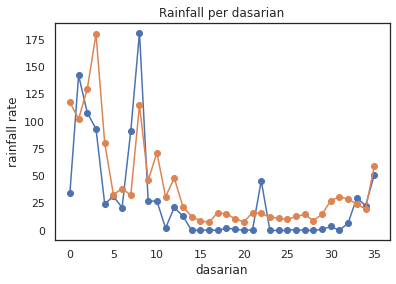

In [ ]:
plt.plot(rain_10d, marker='o')
plt.plot(rain_10d_pred, marker='o')
plt.title("Rainfall per dasarian")
plt.ylabel("rainfall rate")
plt.xlabel("dasarian")
plt.show()

In [ ]:
rain_10d_pred = np.array(rain_10d_pred)
rain_10d = np.array(rain_10d)

In [ ]:
np.where(rain_10d > 50)

(array([ 1,  2,  3,  7,  8, 35]),)

In [ ]:
np.where(rain_10d_pred > 50)

(array([ 0,  1,  2,  3,  4,  8, 10, 35]),)